In [1]:
import numpy as np
import random
import os
import cv2
import nibabel as nib
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import glob
from delete_bed import delete_bed_torch
from skimage.filters import median
from skimage.morphology import cube

In [2]:
def create_nonzero_mask(data):
    from scipy.ndimage import binary_fill_holes
    assert len(data.shape) == 3 or len(data.shape) == 2, "data must have shape (X, Y, Z) or shape (X, Y)"
    nonzero_mask = (data > 100)
    nonzero_mask = binary_fill_holes(nonzero_mask)
    return nonzero_mask


def get_bbox_from_mask(mask, outside_value=0):
    mask_voxel_coords = np.where(mask != outside_value)
    minzidx = int(np.min(mask_voxel_coords[0]))
    maxzidx = int(np.max(mask_voxel_coords[0])) + 1
    minxidx = int(np.min(mask_voxel_coords[1]))
    maxxidx = int(np.max(mask_voxel_coords[1])) + 1
    minyidx = int(np.min(mask_voxel_coords[2]))
    maxyidx = int(np.max(mask_voxel_coords[2])) + 1
    return [[minzidx, maxzidx], [minxidx, maxxidx], [minyidx, maxyidx]]


def crop_to_bbox(image, bbox):
    assert len(image.shape) == 3, "only supports 3d images"
    resizer = (slice(bbox[0][0], bbox[0][1]), slice(bbox[1][0], bbox[1][1]), slice(bbox[2][0], bbox[2][1]))
    return image[resizer]

def crop_to_nonzero(data, seg=None, nonzero_label=-1):

    """
    :param data:
    :param seg:
    :param nonzero_label: this will be written into the segmentation map
    :return:
    """

    nonzero_mask = create_nonzero_mask(data)
    bbox = get_bbox_from_mask(nonzero_mask, 0)

    data = crop_to_bbox(data, bbox)

    return data, bbox

def z_score(imgs,clip_min,clip_max):
    imgs = np.clip(imgs, clip_min, clip_max)
    mean = imgs.mean()
    std = imgs.std()
    imgs = (imgs - mean) / std
    imgs = np.clip(imgs,-3,3)
    return imgs

def min_max_normalization(imgs,min_v,max_v):
    imgs = np.clip(imgs, min_v, max_v)
    imgs = (imgs - min_v) / (max_v - min_v)
    return imgs

def resample_data(data,new_shape,is_seg=False):
    from skimage.transform import resize
    if is_seg:
        resized_data = resize(data, new_shape, order=0, mode="edge", clip=True, anti_aliasing=False).astype(np.uint8)
    else:
        resized_data = resize(data, new_shape, order=3,mode="edge", clip=True, anti_aliasing=False).astype(np.int16)
    return resized_data

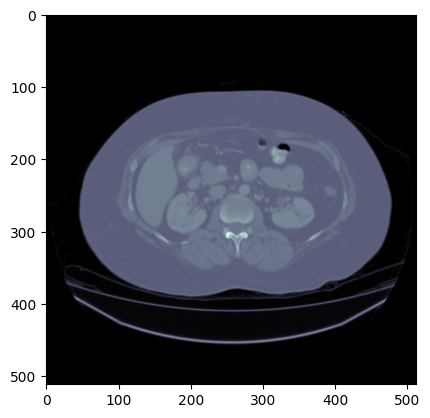

In [3]:
num2label={1:1,2:2,3:3,6:4}
data_path = "/home/zhuaiaa/proaligncl/data/abdomen15/RawData/Training/img/img0039.nii.gz"
label_path = "/home/zhuaiaa/proaligncl/data/abdomen15/RawData/Training/label/label0039.nii.gz"
data = sitk.ReadImage(data_path)
data = sitk.GetArrayFromImage(data)
label = sitk.ReadImage(label_path)
label = sitk.GetArrayFromImage(label)
new_label = np.zeros_like(label).astype(np.uint8)
data = np.flip(data.transpose(1,2,0),axis=0)
# for k,v in num2label.items():
#     new_label[label==k] = v
# organ_range_z = get_bbox_from_mask((new_label>0).astype(np.uint8))[0]

# print(data.shape)
# # data = data[organ_range_z[0]:organ_range_z[1]]
# # new_label = new_label[organ_range_z[0]:organ_range_z[1]]
# _,bbox = delete_bed_torch(data)
# # crop_organ_data = crop_to_bbox(data,bbox)
# # crop_organ_label = crop_to_bbox(new_label,bbox)
# crop_data = crop_to_bbox(data,bbox)
# new_label = crop_to_bbox(new_label,bbox)

# crop_organ_data = crop_data[organ_range_z[0]:organ_range_z[1]]
# crop_organ_label = new_label[organ_range_z[0]:organ_range_z[1]]
# # print(np.unique(crop_organ_label))
# # print(crop_organ_data.shape,crop_organ_label.shape)
# resized_data = resample_data(crop_organ_data.astype(float),(crop_organ_data.shape[0],256,256),False)
# resized_label = resample_data(crop_organ_label.astype(float),(crop_organ_label.shape[0],256,256),True)
# print(resized_data.shape,resized_label.shape)
plt.imshow(data[:,:,60],cmap='bone')
plt.show()

# out_data = sitk.GetImageFromArray(resized_data)
# sitk.WriteImage(out_data,'img0039.nii.gz')
# print(np.unique(resized_label))
# out_label = sitk.GetImageFromArray(resized_label)
# sitk.WriteImage(out_label,'label0039.nii.gz')

In [4]:
num2label={1:1,2:2,3:3,6:4}
img_dir = "/home/zhuaiaa/proaligncl/data/abdomen15/RawData/Training/img/"
label_dir = "/home/zhuaiaa/proaligncl/data/abdomen15/RawData/Training/label/"
# save_dir = "/mnt/sda/qinji/Domain_Adaptation/data/Abdomen_CT/preprocessed_data/"
save_dir = "/home/zhuaiaa/proaligncl/preprocess/Abdomen_CT/preprocessed_data_new/"
# for img_name in os.listdir(img_dir):
#     label_name = 'label'+img_name[3:]
#     img = sitk.ReadImage(os.path.join(img_dir,img_name))
#     img = sitk.GetArrayFromImage(img)
#     label = sitk.ReadImage(os.path.join(label_dir,label_name))
#     label = sitk.GetArrayFromImage(label)
#     new_label = np.zeros_like(label).astype(np.uint8)
#     for k,v in num2label.items():
#         new_label[label==k] = v
#     organ_range_z = get_bbox_from_mask((new_label>0).astype(np.uint8))[0]
#     print(img.shape,label.shape)
#     img = img[organ_range_z[0]:organ_range_z[1]]
#     new_label = new_label[organ_range_z[0]:organ_range_z[1]]
#     print(img.shape,new_label.shape)
#     _,bbox = delete_bed_torch(img)
#     crop_organ_img = crop_to_bbox(img,bbox)
#     crop_organ_label = crop_to_bbox(new_label,bbox)
#     print(crop_organ_img.shape,crop_organ_label.shape)
#     resized_img = resample_data(crop_organ_img.astype(float),(crop_organ_img.shape[0],256,256),False)
#     resized_label = resample_data(crop_organ_label.astype(float),(crop_organ_label.shape[0],256,256),True)
#     out_img = sitk.GetImageFromArray(resized_img)
#     sitk.WriteImage(out_img,os.path.join(save_dir,'img',img_name))
#     print(np.unique(resized_label))
#     out_label = sitk.GetImageFromArray(resized_label)
#     sitk.WriteImage(out_label,os.path.join(save_dir,'label',label_name))

for img_name in os.listdir(img_dir):
    label_name = 'label'+img_name[3:]
    img = sitk.ReadImage(os.path.join(img_dir,img_name))
    img = sitk.GetArrayFromImage(img)
    label = sitk.ReadImage(os.path.join(label_dir,label_name))
    label = sitk.GetArrayFromImage(label)
    new_label = np.zeros_like(label).astype(np.uint8)
    for k,v in num2label.items():
        new_label[label==k] = v
    organ_range_z = get_bbox_from_mask((new_label>0).astype(np.uint8))[0]
    print(img.shape,label.shape)
    img = img[organ_range_z[0]:organ_range_z[1]]
    new_label = new_label[organ_range_z[0]:organ_range_z[1]]
    print(img.shape,new_label.shape)
    resized_img = resample_data(img.astype(float),(img.shape[0],256,256),False)
    resized_label = resample_data(new_label.astype(float),(new_label.shape[0],256,256),True)
    out_img = sitk.GetImageFromArray(resized_img)
    sitk.WriteImage(out_img,os.path.join(save_dir,'img',img_name))
    print(np.unique(resized_label))
    out_label = sitk.GetImageFromArray(resized_label)
    sitk.WriteImage(out_label,os.path.join(save_dir,'label',label_name))

(163, 512, 512) (163, 512, 512)
(78, 512, 512) (78, 512, 512)
[0 1 2 3 4]
(147, 512, 512) (147, 512, 512)
(80, 512, 512) (80, 512, 512)
[0 1 2 3 4]
(144, 512, 512) (144, 512, 512)
(64, 512, 512) (64, 512, 512)
[0 1 2 3 4]
(90, 512, 512) (90, 512, 512)
(41, 512, 512) (41, 512, 512)
[0 1 2 3 4]
(104, 512, 512) (104, 512, 512)
(45, 512, 512) (45, 512, 512)
[0 1 2 3 4]
(89, 512, 512) (89, 512, 512)
(36, 512, 512) (36, 512, 512)
[0 1 2 3 4]
(99, 512, 512) (99, 512, 512)
(35, 512, 512) (35, 512, 512)
[0 1 2 3 4]
(100, 512, 512) (100, 512, 512)
(44, 512, 512) (44, 512, 512)
[0 1 2 3 4]
(100, 512, 512) (100, 512, 512)
(65, 512, 512) (65, 512, 512)
[0 1 2 3 4]
(153, 512, 512) (153, 512, 512)
(63, 512, 512) (63, 512, 512)
[0 1 2 3 4]
(88, 512, 512) (88, 512, 512)
(43, 512, 512) (43, 512, 512)
[0 1 2 3 4]
(96, 512, 512) (96, 512, 512)
(37, 512, 512) (37, 512, 512)
[0 1 2 3 4]
(124, 512, 512) (124, 512, 512)
(56, 512, 512) (56, 512, 512)
[0 1 2 3 4]
(148, 512, 512) (148, 512, 512)
(54, 512, 512) (

(30, 256, 256) (30, 256, 256)
(24, 256, 256) (24, 256, 256)
(24, 160, 208) (24, 160, 208)
(24, 256, 256) (24, 256, 256)
[0 1 2 3 4]


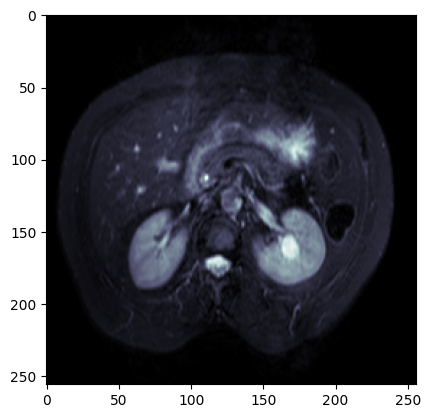

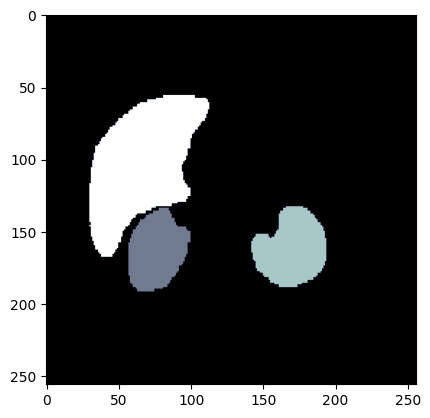

In [5]:
num2label={63:4,126:2,189:3,252:1}
img_path = "/home/zhuaiaa/proaligncl/data/chaos/Train_Sets/MR/5/T2SPIR/DICOM_anon/"
label_path = "/home/zhuaiaa/proaligncl/data/chaos/Train_Sets/MR/5/T2SPIR/Ground/"
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(img_path)
reader.SetFileNames(dicom_names)
img = reader.Execute()
img = sitk.GetArrayFromImage(img)

label_path_list = sorted(glob.glob(os.path.join(label_path,'*.png')))
label = [cv2.imread(path,0) for path in label_path_list]
label = np.stack(label,axis=0)
print(img.shape,label.shape)
new_label = np.zeros_like(label).astype(np.uint8)
for k,v in num2label.items():
    new_label[label==k] = v
organ_range_z = get_bbox_from_mask((new_label>0).astype(np.uint8))[0]
img = img[organ_range_z[0]:organ_range_z[1]]
new_label = new_label[organ_range_z[0]:organ_range_z[1]]
print(img.shape,new_label.shape)

_,bbox = crop_to_nonzero(img) 

crop_organ_img = crop_to_bbox(img,bbox)
crop_organ_label = crop_to_bbox(new_label,bbox)
print(crop_organ_img.shape,crop_organ_label.shape)

resized_img = resample_data(crop_organ_img.astype(float),(crop_organ_img.shape[0],256,256),False)
resized_label = resample_data(crop_organ_label.astype(float),(crop_organ_label.shape[0],256,256),True)
print(resized_img.shape,resized_label.shape)
out_img = sitk.GetImageFromArray(resized_img)
sitk.WriteImage(out_img,'img_8.nii.gz')
print(np.unique(resized_label))
out_label = sitk.GetImageFromArray(resized_label)
sitk.WriteImage(out_label,'label_8.nii.gz')
plt.imshow(resized_img[10],cmap='bone')
plt.show()
plt.imshow(resized_label[10]*50,cmap='bone')
plt.show()

In [6]:
num2label={63:4,126:2,189:3,252:1}
data_dir = "/home/zhuaiaa/proaligncl/data/chaos/Train_Sets/MR/"
# save_dir = "/mnt/sda/qinji/Domain_Adaptation/data/Abdomen_MR/preprocessed_data/"
save_dir = "/home/zhuaiaa/proaligncl/preprocess/Abdomen_MR/preprocessed_data_new/"
# for num in os.listdir(data_dir):
#     img_dir = os.path.join(data_dir,num,"T2SPIR/DICOM_anon/")
#     label_dir = os.path.join(data_dir,num,"T2SPIR/Ground/")
#     reader = sitk.ImageSeriesReader()
#     dicom_names = reader.GetGDCMSeriesFileNames(img_dir)
#     reader.SetFileNames(dicom_names)
#     img = reader.Execute()
#     img = sitk.GetArrayFromImage(img)

#     label_path_list = sorted(glob.glob(os.path.join(label_dir,'*.png')))
#     label = [cv2.imread(path,0) for path in label_path_list]
#     label = np.stack(label,axis=0)
#     name = os.path.basename(label_path_list[0])[:-10]
#     print(num,name)
#     print(img.shape,label.shape)
#     new_label = np.zeros_like(label).astype(np.uint8)
#     for k,v in num2label.items():
#         new_label[label==k] = v
#     organ_range_z = get_bbox_from_mask((new_label>0).astype(np.uint8))[0]
#     img = img[organ_range_z[0]:organ_range_z[1]]
#     new_label = new_label[organ_range_z[0]:organ_range_z[1]]
#     print(img.shape,new_label.shape)

#     _,bbox = crop_to_nonzero(img) 

#     crop_organ_img = crop_to_bbox(img,bbox)
#     crop_organ_label = crop_to_bbox(new_label,bbox)
#     print(crop_organ_img.shape,crop_organ_label.shape)

#     resized_img = resample_data(crop_organ_img.astype(float),(crop_organ_img.shape[0],256,256),False)
#     resized_label = resample_data(crop_organ_label.astype(float),(crop_organ_label.shape[0],256,256),True)
#     print(resized_img.shape,resized_label.shape)
#     out_img = sitk.GetImageFromArray(resized_img)
#     sitk.WriteImage(out_img,os.path.join(save_dir,'img','{}-{}.nii.gz'.format(name,num)))
#     print(np.unique(resized_label))
#     out_label = sitk.GetImageFromArray(resized_label)
#     sitk.WriteImage(out_label,os.path.join(save_dir,'label','{}-{}.nii.gz'.format(name,num)))
for num in os.listdir(data_dir):
    img_dir = os.path.join(data_dir,num,"T2SPIR/DICOM_anon/")
    label_dir = os.path.join(data_dir,num,"T2SPIR/Ground/")
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(img_dir)
    reader.SetFileNames(dicom_names)
    img = reader.Execute()
    img = sitk.GetArrayFromImage(img)

    label_path_list = sorted(glob.glob(os.path.join(label_dir,'*.png')))
    label = [cv2.imread(path,0) for path in label_path_list]
    label = np.stack(label,axis=0)
    name = os.path.basename(label_path_list[0])[:-10]
    print(num,name)
    print(img.shape,label.shape)
    new_label = np.zeros_like(label).astype(np.uint8)
    for k,v in num2label.items():
        new_label[label==k] = v
    organ_range_z = get_bbox_from_mask((new_label>0).astype(np.uint8))[0]
    img = img[organ_range_z[0]:organ_range_z[1]]
    new_label = new_label[organ_range_z[0]:organ_range_z[1]]
    print(img.shape,new_label.shape)


    resized_img = resample_data(img.astype(float),(img.shape[0],256,256),False)
    resized_label = resample_data(new_label.astype(float),(new_label.shape[0],256,256),True)
    print(resized_img.shape,resized_label.shape)
    out_img = sitk.GetImageFromArray(resized_img)
    sitk.WriteImage(out_img,os.path.join(save_dir,'img','{}-{}.nii.gz'.format(name,num)))
    print(np.unique(resized_label))
    out_label = sitk.GetImageFromArray(resized_label)
    sitk.WriteImage(out_label,os.path.join(save_dir,'label','{}-{}.nii.gz'.format(name,num)))

21 IMG-0001
(31, 256, 256) (31, 256, 256)
(21, 256, 256) (21, 256, 256)
(21, 256, 256) (21, 256, 256)
[0 1 2 3 4]
31 IMG-0026
(29, 256, 256) (29, 256, 256)
(20, 256, 256) (20, 256, 256)
(20, 256, 256) (20, 256, 256)
[0 1 2 3 4]
36 IMG-0016
(38, 256, 256) (38, 256, 256)
(23, 256, 256) (23, 256, 256)
(23, 256, 256) (23, 256, 256)
[0 1 2 3 4]
37 IMG-0020
(32, 256, 256) (32, 256, 256)
(24, 256, 256) (24, 256, 256)
(24, 256, 256) (24, 256, 256)
[0 1 2 3 4]
39 IMG-0026
(26, 256, 256) (26, 256, 256)
(22, 256, 256) (22, 256, 256)
(22, 256, 256) (22, 256, 256)
[0 1 2 3 4]
38 IMG-0022
(34, 320, 320) (34, 320, 320)
(24, 320, 320) (24, 320, 320)
(24, 256, 256) (24, 256, 256)
[0 1 2 3 4]
33 IMG-0034
(29, 256, 256) (29, 256, 256)
(27, 256, 256) (27, 256, 256)
(27, 256, 256) (27, 256, 256)
[0 1 2 3 4]
15 IMG-0073
(26, 256, 256) (26, 256, 256)
(26, 256, 256) (26, 256, 256)
(26, 256, 256) (26, 256, 256)
[0 1 2 3 4]
10 IMG-0043
(36, 256, 256) (36, 256, 256)
(25, 256, 256) (25, 256, 256)
(25, 256, 256) (

In [7]:
img_dir = "/home/zhuaiaa/proaligncl/preprocess/Abdomen_CT/preprocessed_data_new/img/"
label_dir = "/home/zhuaiaa/proaligncl/preprocess/Abdomen_CT/preprocessed_data_new/label/"
site_dir = "/home/zhuaiaa/proaligncl/data/preprocess/Abdomen_Data_new/CT/"
img_list = os.listdir(img_dir)
random.seed(999)
random.shuffle(img_list)
train_img_list = img_list[:int(0.8*len(img_list))]
test_img_list = img_list[int(0.8*len(img_list)):]
print(train_img_list)
print(test_img_list)

['img0035.nii.gz', 'img0005.nii.gz', 'img0022.nii.gz', 'img0024.nii.gz', 'img0038.nii.gz', 'img0008.nii.gz', 'img0010.nii.gz', 'img0001.nii.gz', 'img0003.nii.gz', 'img0006.nii.gz', 'img0040.nii.gz', 'img0031.nii.gz', 'img0023.nii.gz', 'img0007.nii.gz', 'img0030.nii.gz', 'img0029.nii.gz', 'img0004.nii.gz', 'img0037.nii.gz', 'img0039.nii.gz', 'img0027.nii.gz', 'img0025.nii.gz', 'img0033.nii.gz', 'img0021.nii.gz', 'img0026.nii.gz']
['img0002.nii.gz', 'img0034.nii.gz', 'img0009.nii.gz', 'img0032.nii.gz', 'img0028.nii.gz', 'img0036.nii.gz']


In [8]:
for img_name in train_img_list:
    label_name = 'label'+img_name[3:]
    img = sitk.ReadImage(os.path.join(img_dir,img_name))
    img = sitk.GetArrayFromImage(img)
    label = sitk.ReadImage(os.path.join(label_dir,label_name))
    label = sitk.GetArrayFromImage(label)
    # mean,std = np.mean(img),np.std(img)
    # img = z_score(img,-125,275)
    # min_v,max_v = img.min(),img.max()
    # img = (img - min_v) / (max_v-min_v)
    # img = min_max_normalization(img,-1.0582,4.3029)
    img = min_max_normalization(img,-125,275)
    img = np.flip(img.transpose((1,2,0)),axis=0)
    label = np.flip(label.transpose((1,2,0)),axis=0)
    for index in range(img.shape[2]):
        if index==0:
            img_ = img[:,:,[0,0,0]]#img_ = img[:,:,[0,0,1]]
        elif index==img.shape[2]-1:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,[index-1,index,index]]
        else:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,index-1:index+2]
        seg = label[:,:,index]
        assert img_.shape[2]==3
        np.savez(os.path.join(site_dir,'train','{}_{}.npz'.format(img_name[3:7],index)),image = img_,label = seg)

for img_name in test_img_list:
    label_name = 'label'+img_name[3:]
    img = sitk.ReadImage(os.path.join(img_dir,img_name))
    img = sitk.GetArrayFromImage(img)
    label = sitk.ReadImage(os.path.join(label_dir,label_name))
    label = sitk.GetArrayFromImage(label)
    # mean,std = np.mean(img),np.std(img)
    # img = normalization(img,mean,std)
    # img = z_score(img,-125,275)
    # min_v,max_v = img.min(),img.max()
    # img = (img - min_v) / (max_v-min_v)
    img = min_max_normalization(img,-125,275)
    img = np.flip(img.transpose((1,2,0)),axis=0)
    label = np.flip(label.transpose((1,2,0)),axis=0)
    for index in range(img.shape[2]):
        if index==0:
            img_ = img[:,:,[0,0,0]]#img_ = img[:,:,[0,0,1]]
        elif index==img.shape[2]-1:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,[index-1,index,index]]
        else:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,index-1:index+2]
        seg = label[:,:,index]
        assert img_.shape[2]==3
        np.savez(os.path.join(site_dir,'test','{}_{}.npz'.format(img_name[3:7],index)),image = img_,label = seg)


In [9]:
img_dir = "/home/zhuaiaa/proaligncl/preprocess/Abdomen_MR/preprocessed_data_new/img/"
label_dir = "/home/zhuaiaa/proaligncl/preprocess/Abdomen_MR/preprocessed_data_new/label/"
site_dir = "/home/zhuaiaa/proaligncl/data/preprocess/Abdomen_Data_new/MR/"
img_list = os.listdir(img_dir)
random.seed(999)
random.shuffle(img_list)
train_img_list = img_list[:int(0.8*len(img_list))]
test_img_list = img_list[int(0.8*len(img_list)):]
print(train_img_list)
print(test_img_list)

['IMG-0034-33.nii.gz', 'IMG-0073-15.nii.gz', 'IMG-0007-2.nii.gz', 'IMG-0026-39.nii.gz', 'IMG-0008-22.nii.gz', 'IMG-0016-36.nii.gz', 'IMG-0014-5.nii.gz', 'IMG-0029-20.nii.gz', 'IMG-0002-1.nii.gz', 'IMG-0030-32.nii.gz', 'IMG-0061-13.nii.gz', 'IMG-0026-31.nii.gz', 'IMG-0022-38.nii.gz', 'IMG-0043-10.nii.gz', 'IMG-0001-21.nii.gz', 'IMG-0008-34.nii.gz']
['IMG-0031-8.nii.gz', 'IMG-0020-37.nii.gz', 'IMG-0002-3.nii.gz', 'IMG-0024-19.nii.gz']


In [16]:
train_img_list = ['IMG-0014-5.nii.gz', 'IMG-0002-1.nii.gz', 'IMG-0073-15.nii.gz', 'IMG-0001-21.nii.gz', 'IMG-0022-38.nii.gz', 'IMG-0034-33.nii.gz', 'IMG-0043-10.nii.gz', 'IMG-0029-20.nii.gz', 'IMG-0002-3.nii.gz', 'IMG-0016-36.nii.gz', 'IMG-0030-32.nii.gz', 'IMG-0026-39.nii.gz', 'IMG-0008-22.nii.gz', 'IMG-0061-13.nii.gz', 'IMG-0024-19.nii.gz', 'IMG-0020-37.nii.gz']
test_img_list = ['IMG-0026-31.nii.gz', 'IMG-0008-34.nii.gz', 'IMG-0031-8.nii.gz', 'IMG-0007-2.nii.gz']
print(train_img_list)
print(test_img_list)

['IMG-0014-5.nii.gz', 'IMG-0002-1.nii.gz', 'IMG-0073-15.nii.gz', 'IMG-0001-21.nii.gz', 'IMG-0022-38.nii.gz', 'IMG-0034-33.nii.gz', 'IMG-0043-10.nii.gz', 'IMG-0029-20.nii.gz', 'IMG-0002-3.nii.gz', 'IMG-0016-36.nii.gz', 'IMG-0030-32.nii.gz', 'IMG-0026-39.nii.gz', 'IMG-0008-22.nii.gz', 'IMG-0061-13.nii.gz', 'IMG-0024-19.nii.gz', 'IMG-0020-37.nii.gz']
['IMG-0026-31.nii.gz', 'IMG-0008-34.nii.gz', 'IMG-0031-8.nii.gz', 'IMG-0007-2.nii.gz']


In [17]:
for img_name in train_img_list:
    label_name = img_name
    img = sitk.ReadImage(os.path.join(img_dir,img_name))
    img = sitk.GetArrayFromImage(img)
    label = sitk.ReadImage(os.path.join(label_dir,label_name))
    label = sitk.GetArrayFromImage(label)
    # mean,std = np.mean(img),np.std(img)
    # img = z_score(img,0,1200)
    img = min_max_normalization(img,0,1200)
    # min_v = np.percentile(img,5)
    # max_v = np.percentile(img,95)
    # img = min_max_normalization(img,min_v,max_v)
    img = img.transpose((1,2,0))
    label = label.transpose((1,2,0))
    for index in range(img.shape[2]):
        if index==0:
            img_ = img[:,:,[0,0,0]]#img_ = img[:,:,[0,0,1]]
        elif index==img.shape[2]-1:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,[index-1,index,index]]
        else:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,index-1:index+2]
        seg = label[:,:,index]
        assert img_.shape[2]==3
        np.savez(os.path.join(site_dir,'train','{}_{}.npz'.format(img_name[:-7],index)),image = img_,label = seg)

for img_name in test_img_list:
    label_name = img_name
    img = sitk.ReadImage(os.path.join(img_dir,img_name))
    img = sitk.GetArrayFromImage(img)
    label = sitk.ReadImage(os.path.join(label_dir,label_name))
    label = sitk.GetArrayFromImage(label)
    # mean,std = np.mean(img),np.std(img)
    # img = z_score(img,0,1200)
    img = min_max_normalization(img,0,1200)
    # min_v = np.percentile(img,5)
    # max_v = np.percentile(img,95)
    # img = min_max_normalization(img,min_v,max_v)
    img = img.transpose((1,2,0))
    label = label.transpose((1,2,0))
    for index in range(img.shape[2]):
        if index==0:
            img_ = img[:,:,[0,0,0]]#img_ = img[:,:,[0,0,1]]
        elif index==img.shape[2]-1:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,[index-1,index,index]]
        else:
            img_ = img[:,:,[index,index,index]]#img_ = img[:,:,index-1:index+2]
        seg = label[:,:,index]
        assert img_.shape[2]==3
        np.savez(os.path.join(site_dir,'test','{}_{}.npz'.format(img_name[:-7],index)),image = img_,label = seg)